In [2]:
!pip install "scikit-learn == 0.24.2"
!pip install signed_backbones

You should consider upgrading via the 'c:\users\furkan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\furkan\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [19]:
import pandas as pd
import numpy as np
import numpy.linalg as LA
import networkx as nx
from scipy.stats import gaussian_kde
import random
import signed_backbones as sb

from sklearn.metrics import normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

import signed_backbones as sb

from sklearn.cluster import DBSCAN

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.style.use('extensys-gd')
plt.style.use('seaborn-colorblind')


In [4]:
data = pd.read_csv('input/migration.csv', header = None).fillna(method='ffill')
data = data.loc[data[3] != 0,:].reset_index(drop=True)
data.columns = ['year', 'source', 'target', 'value']
data.year = data.year.astype(int)
data.head(3)

,year,source,target,value
0,2008,Adana,Adıyaman,864
1,2008,Adana,Afyonkarahisar,202
2,2008,Adana,Ağrı,115


In [5]:
migrants = data.groupby(by='year').sum()
migrants.head(3)

,value
year,
2008,2273492
2009,2236981
2010,2360079


In [6]:
population = pd.read_csv('input/population.csv').set_index('year')
population.head(3)

,pop
year,
2008,71517100
2009,72561312
2010,73722988


In [7]:
results = pd.merge(migrants, population, left_index=True, right_index=True)
results['ratio'] = results['value'] / results['pop']
results.head(3)

,value,pop,ratio
year,,,
2008,2273492,71517100,0.031789
2009,2236981,72561312,0.030829
2010,2360079,73722988,0.032013


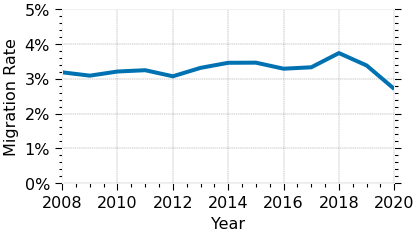

In [8]:
plt.figure(figsize=(6, 3), facecolor='white')
plt.axes().set_facecolor("white")
rate = results.ratio*100
year = results.index
plt.plot(year,rate)
plt.ylim(bottom=0, top = 5)
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))
plt.xlabel("Year")
plt.ylabel("Migration Rate")
plt.show()

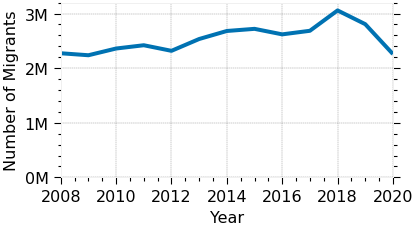

In [9]:
plt.figure(figsize=(6, 3), facecolor='white')
plt.axes().set_facecolor("white")
value = results.value / 1000000
year = results.index
plt.plot(year,value)
plt.ylim(bottom=0)
plt.xlabel("Year")
plt.ylabel("Number of Migrants")
plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%dM'))
plt.show()

In [10]:
# create a separate network for each year
networks = dict()

for year in range(2008, 2021):
  networks[year] = nx.from_pandas_edgelist(data.loc[data.year == year, :], source = 'source', target = 'target', edge_attr = 'value', create_using = nx.DiGraph())

print("Network summary for the latest year:\n", nx.info(networks[2020]))

Network summary for the latest year:
 Name: 
Type: DiGraph
Number of nodes: 81
Number of edges: 6480
Average in degree:  80.0000
Average out degree:  80.0000


In [9]:
print("Density of the networks over the years")
for year in range(2008, 2021):
  print(year, nx.density(networks[year]))


Density of the networks over the years
2008 0.9984567901234568
2009 0.9973765432098766
2010 0.9992283950617284
2011 0.9998456790123457
2012 0.9992283950617284
2013 0.9998456790123457
2014 1.0
2015 0.9996913580246913
2016 1.0
2017 1.0
2018 1.0
2019 0.9998456790123457
2020 1.0


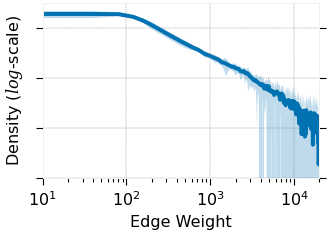

Maximum edge weight over all years is 24884. The plot is cut at 20000.


In [10]:
# edge weight distribution (mean and 2.58 standard deviation over all years)
store = []
xs = np.linspace(0,20000,500)
max_edge_weight = 0
for year in range(2008, 2021):
  edgevalues = nx.get_edge_attributes(networks[year], 'value')
  data = [edgevalues[edge] for edge in edgevalues]
  max_edge_weight = np.max(data)
  density = gaussian_kde(data)
  density.covariance_factor = lambda : 0.05
  density._compute_covariance()
  store.append(density(xs))

means = pd.DataFrame(store).mean(axis = 0)
std = pd.DataFrame(store).std(axis = 0)


plt.figure(figsize=(5, 3), facecolor='white')
plt.axes().set_facecolor("white")
plt.loglog(xs,means)
plt.fill_between(xs, means + 2.58*std, means - 2.58*std,alpha=.25)
plt.xlim(right = 20000)
plt.xlabel('Edge Weight')
plt.ylabel('Density ($log$-scale)')
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

print("Maximum edge weight over all years is {}. The plot is cut at 20000.".format(max_edge_weight))

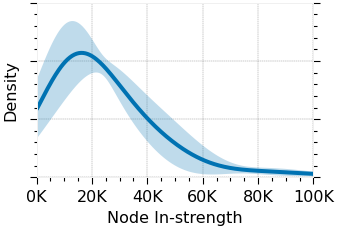

Maximum in-strength over all years is 328632. The plot is cut at 100000.


In [11]:
# instrength distribution (mean and 2.58 standard deviation over all years)
store = []
xs = np.linspace(0,200000,500)
max_strength = 0
for year in range(2008, 2021):
  strengthvalues = dict(networks[year].in_degree(weight = 'value'))
  data = [strengthvalues[node] for node in strengthvalues]
  max_edge_weight = np.max(data)
  density = gaussian_kde(data)
  density.covariance_factor = lambda : 0.25
  density._compute_covariance()
  store.append(density(xs))

means = pd.DataFrame(store).mean(axis = 0)
std = pd.DataFrame(store).std(axis = 0)

xs = xs/1000
plt.figure(figsize=(5, 3), facecolor='white')
plt.axes().set_facecolor("white")
plt.plot(xs,means)
plt.fill_between(xs, means + 2.58*std, means - 2.58*std,alpha=.25)
plt.xlim(right  = 100)
plt.ylim(bottom = 0)
plt.xlabel('Node In-strength')
plt.ylabel('Density')
plt.gca().axes.yaxis.set_ticklabels([])
plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%dK'))
plt.show()


print("Maximum in-strength over all years is {}. The plot is cut at 100000.".format(max_edge_weight))

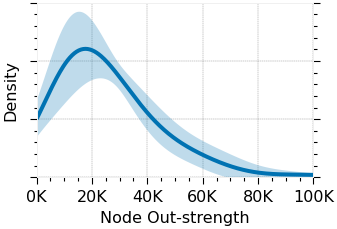

Maximum out-strength over all years is 381654. The plot is cut at 100000.


In [12]:
# outstrength distribution (mean and 2.58 standard deviation over all years)
store = []
xs = np.linspace(0,200000,500)
max_strength = 0
for year in range(2008, 2021):
  strengthvalues = dict(networks[year].out_degree(weight = 'value'))
  data = [strengthvalues[node] for node in strengthvalues]
  max_edge_weight = np.max(data)
  density = gaussian_kde(data)
  density.covariance_factor = lambda : 0.25
  density._compute_covariance()
  store.append(density(xs))

means = pd.DataFrame(store).mean(axis = 0)
std = pd.DataFrame(store).std(axis = 0)


xs = xs/1000
plt.figure(figsize=(5, 3), facecolor='white')
plt.axes().set_facecolor("white")
plt.plot(xs,means)
plt.fill_between(xs, means + 2.58*std, means - 2.58*std,alpha=.25)
plt.xlim(right  = 100)
plt.ylim(bottom = 0)
plt.xlabel('Node Out-strength')
plt.ylabel('Density')
plt.gca().axes.yaxis.set_ticklabels([])
plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%dK'))
plt.show()

print("Maximum out-strength over all years is {}. The plot is cut at 100000.".format(max_edge_weight))

In [16]:
r = data.loc[data.year == 2019, :]
r = pd.merge(r.groupby(by = 'source').sum(), r.groupby(by = 'target').sum(), left_index = True, right_index = True).loc[:,['value_x', 'value_y']]
r['netmig'] = r.value_y - r.value_x
cpop = pd.read_csv('input/citypop.csv').set_index('city')
res = pd.merge(r, cpop, left_index=True, right_index=True)
res['netmigration'] = res.netmig/res.pop19 
res.to_csv('output/netmigration.csv')

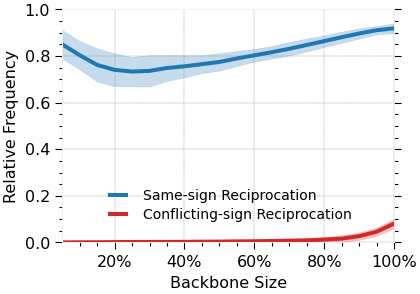

In [126]:
rec_data = pd.read_csv('output/reciprocity.csv').loc[:, ['sigma', 'reciprocated', 'conflict']]
rec_data.head(3)
means = rec_data.groupby(by = 'sigma').mean()
std   = rec_data.groupby(by = 'sigma').std()

plt.figure(figsize=(6, 4), facecolor='white')
plt.axes().set_facecolor("white")

plt.plot(means.index, means.reciprocated, label = 'Same-sign Reciprocation', c = 'tab:blue')
plt.fill_between(means.index, list(means.reciprocated + 2.58*std.reciprocated), list(means.reciprocated - 2.58*std.reciprocated),alpha=.25, color = 'tab:blue')

plt.plot(means.index, means.conflict, label = 'Conflicting-sign Reciprocation', c = 'tab:red')
plt.fill_between(means.index, list(means.conflict + 2.58*std.conflict), list(means.conflict - 2.58*std.conflict),alpha=.25, color = 'tab:red')

plt.xlim(left = 5, right  = 100)
plt.ylim(bottom = 0, top = 1)
plt.gca().xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))
plt.xlabel('Backbone Size')
plt.ylabel('Relative Frequency')

plt.legend(loc=8, borderpad = 2)
plt.show()

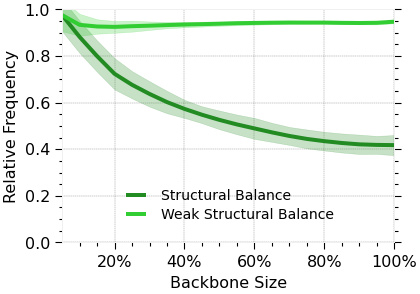

In [130]:
sb_data = pd.read_csv('output/structural_balance.csv').loc[:, ['sigma', 'sb', 'wsb']]
sb_data.head(3)
means = sb_data.groupby(by = 'sigma').mean()
std   = sb_data.groupby(by = 'sigma').std()



plt.figure(figsize=(6, 4), facecolor='white')
plt.axes().set_facecolor("white")

plt.plot(means.index, means.sb, label = 'Structural Balance', c = 'forestgreen')
plt.fill_between(means.index, list(means.sb + 2.58*std.sb), list(means.sb - 2.58*std.sb),alpha=.25, color = 'forestgreen')

plt.plot(means.index, means.wsb, label = 'Weak Structural Balance', c = 'limegreen')
plt.fill_between(means.index, list(means.wsb + 2.58*std.wsb), list(means.wsb - 2.58*std.wsb),alpha=.25, color = 'limegreen')

plt.xlim(left = 5, right  = 100)
plt.ylim(bottom = 0, top = 1)
plt.gca().xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))
plt.xlabel('Backbone Size')
plt.ylabel('Relative Frequency')

plt.legend(loc=8, borderpad = 2)
plt.show()

## Draw spatial

In [16]:
city_meta  = pd.read_csv('input/city_meta.csv')

##### 2020

Iterative fitting procedure converged at iteration 8.
392 edges are retained.
Out of 81 nodes, 81 are retained.


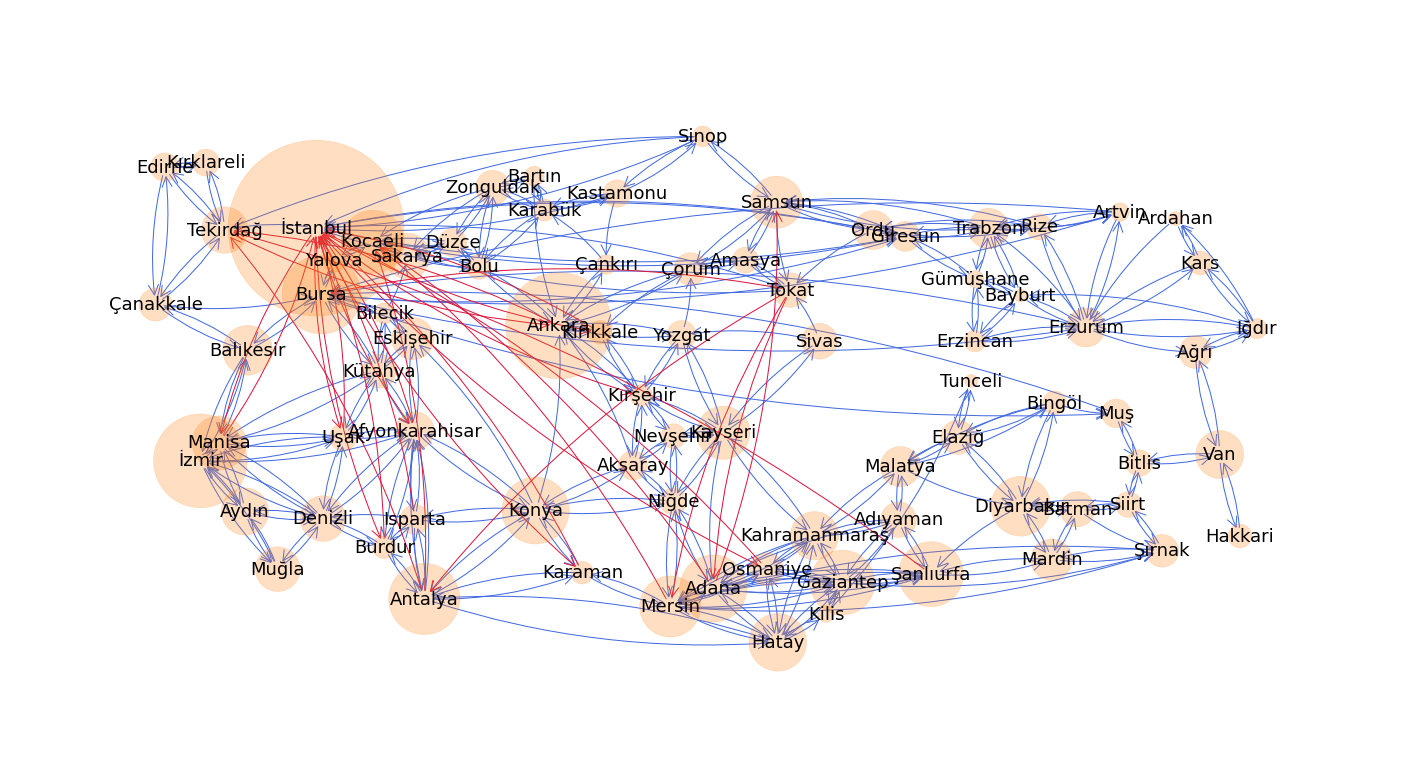

In [17]:
# overall visualization backbone for 2020
bb_edges =  sb.extract(nx.to_pandas_edgelist(networks[2020]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=True, return_significance=True)

backbone = nx.DiGraph()
for row in bb_edges:
    backbone.add_edge(row[0], row[1], weight=row[2])

print("Out of 81 nodes, {} are retained.".format(backbone.number_of_nodes()))

plt.figure(figsize=(20, 11), facecolor='white')


pos = dict()
for i, row in city_meta.iterrows():
  pos[row.city] = np.array([row.long, row.lat])



nodes = []
for node in backbone:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2020']/500)



nx.draw_networkx_nodes(backbone, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] < 0]


nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(backbone, pos, font_size=18, font_family="sans-serif", )

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

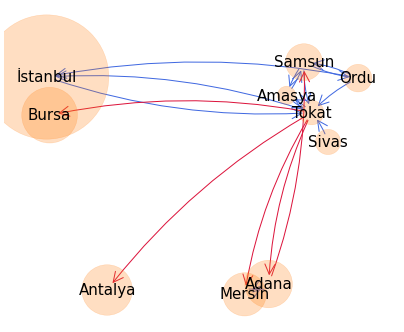

In [18]:
# Egonet for Tokat for 2020
ego = nx.ego_graph(backbone, 'Tokat', undirected = True)

plt.figure(figsize=(6, 5), facecolor='white')

nodes = []
for node in ego:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2020']/1000)

nx.draw_networkx_nodes(ego, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

eposweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
enegweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(ego, pos, font_size=15, font_family="sans-serif", )

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

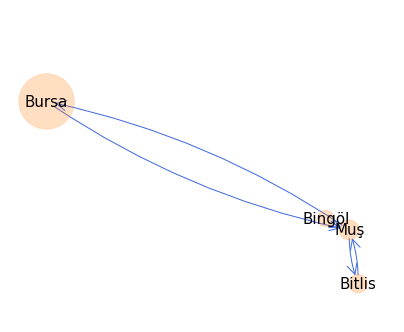

In [19]:
# Egonet for Muş for 2020
ego = nx.ego_graph(backbone, 'Muş', undirected = True)

plt.figure(figsize=(6, 5), facecolor='white')

nodes = []
for node in ego:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2020']/1000)

nx.draw_networkx_nodes(ego, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

eposweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
enegweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(ego, pos, font_size=15, font_family="sans-serif", )

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

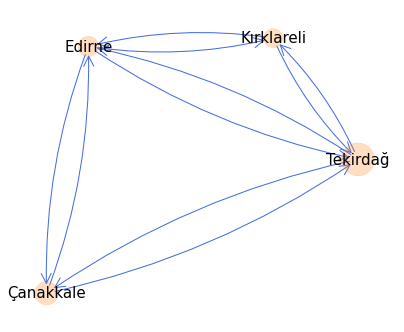

In [20]:
# Egonet for Edirne for 2020
ego = nx.ego_graph(backbone, 'Edirne', undirected = True)

plt.figure(figsize=(6, 5), facecolor='white')

nodes = []
for node in ego:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2020']/1000)

nx.draw_networkx_nodes(ego, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

eposweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
enegweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(ego, pos, font_size=15, font_family="sans-serif", )

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

##### 2008

Iterative fitting procedure converged at iteration 8.
397 edges are retained.
Out of 81 nodes, 81 are retained.


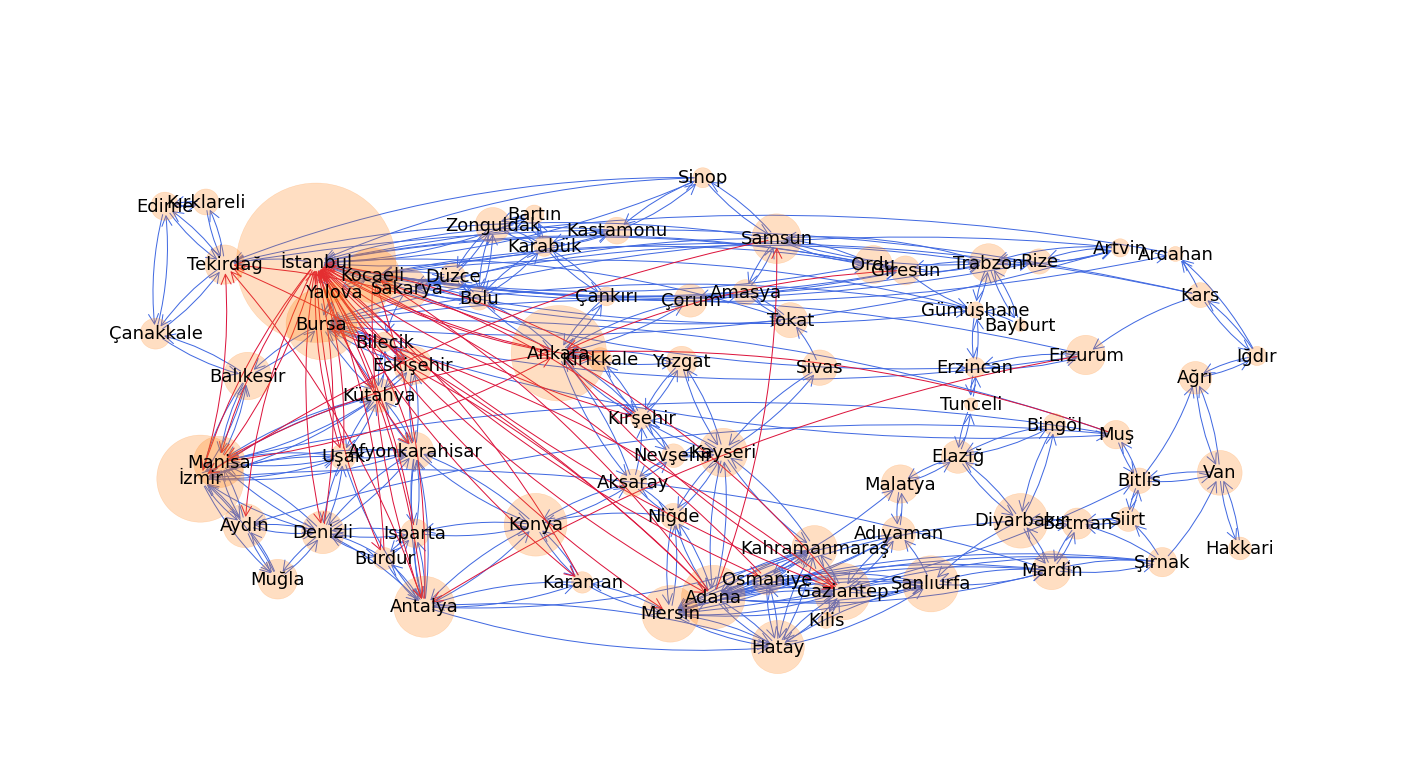

In [26]:
# Overall visualization for backbone for 2008

bb_edges =  sb.extract(nx.to_pandas_edgelist(networks[2008]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=True, return_significance=True)

backbone = nx.DiGraph()
for row in bb_edges:
    backbone.add_edge(row[0], row[1], weight=row[2])

print("Out of 81 nodes, {} are retained.".format(backbone.number_of_nodes()))


plt.figure(figsize=(20, 11), facecolor='white')

pos = dict()
for i, row in city_meta.iterrows():
  pos[row.city] = np.array([row.long, row.lat])


nodes = []
for node in backbone:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2008']/500)



nx.draw_networkx_nodes(backbone, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in backbone.edges(data=True) if d["weight"] < 0]


nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(backbone, pos, font_size=18, font_family="sans-serif", )


ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

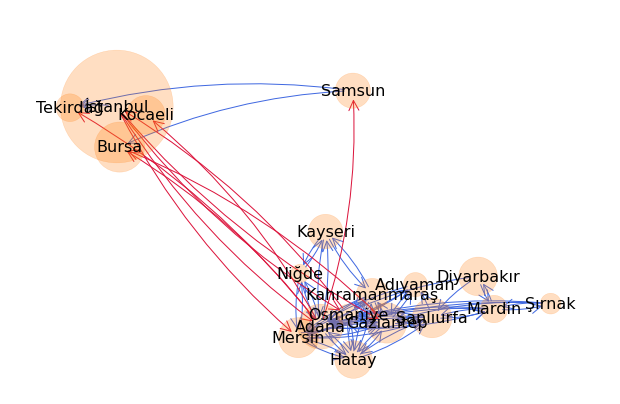

In [50]:
# Egonet for Adana for 2008
ego = nx.ego_graph(backbone, 'Adana', undirected = True)

plt.figure(figsize=(9, 6), facecolor='white')

nodes = []
for node in ego:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2008']/1000)


nx.draw_networkx_nodes(ego, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

eposweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
enegweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(ego, pos, font_size=16, font_family="sans-serif", )

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

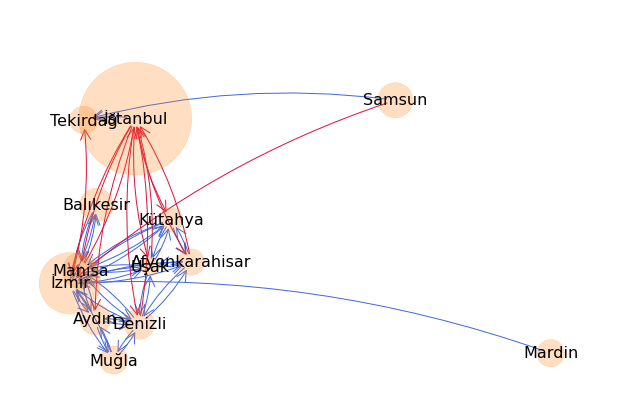

In [51]:
# Egonet for Izmir for 2008
ego = nx.ego_graph(backbone, 'İzmir', undirected = True)

plt.figure(figsize=(9, 6), facecolor='white')

nodes = []
for node in ego:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2008']/1000)


nx.draw_networkx_nodes(ego, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

eposweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
enegweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(ego, pos, font_size=16, font_family="sans-serif", )

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

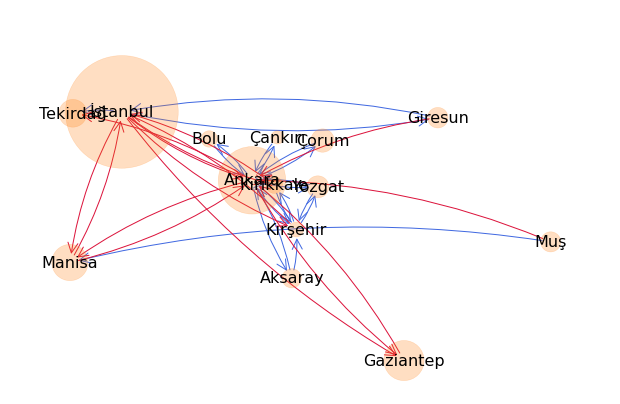

In [52]:
# Egonet for Ankara for 2008
ego = nx.ego_graph(backbone, 'Ankara', undirected = True)

plt.figure(figsize=(9, 6), facecolor='white')

nodes = []
for node in ego:
  nodes.append(node)

node_sizes = []
for node in nodes:
  node_sizes.append(city_meta.set_index('city').loc[node, 'pop2008']/1000)


nx.draw_networkx_nodes(ego, pos, node_color='tab:orange', node_size=node_sizes, alpha = 0.25)

epos = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
eneg = [(u, v) for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

eposweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] > 0]
enegweight  = [d['weight']*2 for (u, v, d) in ego.edges(data=True) if d["weight"] < 0]

nx.draw_networkx_edges(backbone, pos, edgelist=epos, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="royalblue", connectionstyle="arc3,rad=0.1")
nx.draw_networkx_edges(backbone, pos, edgelist=eneg, width = 1, arrowstyle = '->', arrowsize = 25, edge_color="crimson" , connectionstyle="arc3,rad=0.1")

# labels
nx.draw_networkx_labels(ego, pos, font_size=16, font_family="sans-serif", )

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

### Persistance

In [271]:
%%capture
persistance = sb.extract(nx.to_pandas_edgelist(networks[2008]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=False, return_significance=False)
for year in range(2009, 2021):
  bb_edges =  sb.extract(nx.to_pandas_edgelist(networks[year]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=False, return_significance=False)
  persistance = np.concatenate([persistance, bb_edges])

606 directed links appears at least in once over 13 years.


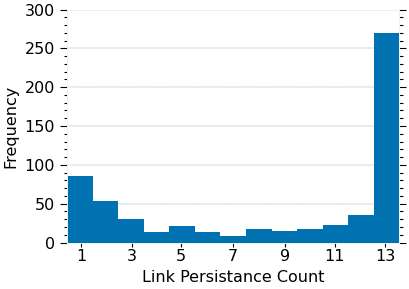

In [272]:
freqs = pd.DataFrame(persistance).groupby(by=[0,1]).count().reset_index().iloc[:, 2]
print("{} directed links appears at least in once over 13 years.".format(len(freqs)))
plt.figure(figsize=(6, 4), facecolor='white')
plt.axes().set_facecolor("white")
plt.hist(freqs, bins=13)
plt.xlim(left = 1, right  = 13)
plt.ylim(bottom = 0)
plt.xlabel('Link Persistance Count')
plt.ylabel('Frequency')
plt.xticks([])
plt.gca().xaxis.set_minor_locator(mpl.ticker.FixedLocator([1.5, 3.33, 5.11, 7, 8.88, 10.66, 12.5]))
plt.gca().xaxis.set_minor_formatter(mpl.ticker.FixedFormatter([1, 3, 5, 7, 9, 11, 13]))
plt.show()


In [273]:
freqs1 = sb.extract(nx.to_pandas_edgelist(networks[2008]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=True, return_significance=True)
for year in range(2009, 2014):
  bb_edges =  sb.extract(nx.to_pandas_edgelist(networks[year]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=True, return_significance=True)
  freqs1 = np.concatenate([freqs1, bb_edges])

freqs1 = pd.DataFrame(freqs1).groupby(by=[0,1], ).count().reset_index()
freqs1.head(3)

Iterative fitting procedure converged at iteration 8.
397 edges are retained.
Iterative fitting procedure converged at iteration 8.
394 edges are retained.
Iterative fitting procedure converged at iteration 8.
402 edges are retained.
Iterative fitting procedure converged at iteration 8.
395 edges are retained.
Iterative fitting procedure converged at iteration 8.
406 edges are retained.
Iterative fitting procedure converged at iteration 8.
405 edges are retained.


,0,1,2,3
0,Adana,Adıyaman,3,3
1,Adana,Bursa,3,3
2,Adana,Gaziantep,6,6


In [274]:
freqs2 = sb.extract(nx.to_pandas_edgelist(networks[2014]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=True, return_significance=True)
for year in range(2015, 2020):
  bb_edges =  sb.extract(nx.to_pandas_edgelist(networks[year]), directed = True, significance_threshold = '7.5pc', vigor_threshold=0.33, return_weights=True, return_significance=True)
  freqs2 = np.concatenate([freqs2, bb_edges])

freqs2 = pd.DataFrame(freqs2).groupby(by=[0,1], ).count().reset_index()
freqs2.head(3)

Iterative fitting procedure converged at iteration 8.
403 edges are retained.
Iterative fitting procedure converged at iteration 8.
398 edges are retained.
Iterative fitting procedure converged at iteration 8.
405 edges are retained.
Iterative fitting procedure converged at iteration 8.
412 edges are retained.
Iterative fitting procedure converged at iteration 8.
416 edges are retained.
Iterative fitting procedure converged at iteration 8.
415 edges are retained.


,0,1,2,3
0,Adana,Balıkesir,1,1
1,Adana,Gaziantep,5,5
2,Adana,Hatay,6,6


597 directed links appears at least in once over 12 years.


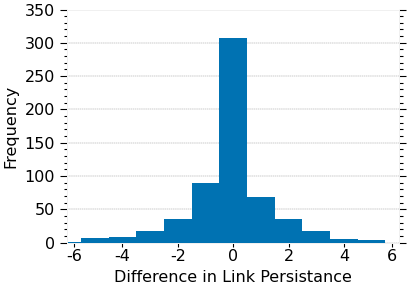

In [275]:
freq12 = pd.merge(freqs1, freqs2, left_on = [0,1], right_on = [0, 1], how='outer').fillna(0)
diff = freq12.loc[:, '2_x'] - freq12.loc[:, '2_y']
print("{} directed links appears at least in once over 12 years.".format(len(diff)))
plt.figure(figsize=(6, 4), facecolor='white')
plt.axes().set_facecolor("white")
plt.hist(diff, bins= [-6.5,-5.5,-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5])
plt.xlim(left = -6, right  = 6)
plt.ylim(bottom = 0)
plt.xlabel('Difference in Link Persistance')
plt.ylabel('Frequency')
plt.xticks([])
plt.gca().xaxis.set_minor_locator(mpl.ticker.FixedLocator(    [-5.75, -4, -2, 0, 2, 4, 5.75]))
plt.gca().xaxis.set_minor_formatter(mpl.ticker.FixedFormatter([-6,    -4, -2, 0, 2, 4, 6]))
plt.show()


#### Embedding loss

In [381]:
cost_by_vs_year = pd.DataFrame()
for year in range(2008,2021):
    for vector_size in range(2,13):
        embloss =  pd.read_csv('output/emb/{}_{}_cost.csv'.format(year, vector_size))
        embloss['year'] = year
        embloss['vector_size'] = vector_size
        cost_by_vs_year = pd.concat([cost_by_vs_year, embloss])
        
cost_by_vs_year['0'] = cost_by_vs_year['0'].astype(float) / (81*80)

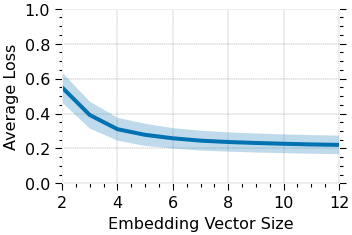

In [384]:
means = cost_by_vs_year.loc[:,['0', 'vector_size']].groupby(by='vector_size').mean()['0']
std   = cost_by_vs_year.loc[:,['0', 'vector_size']].groupby(by='vector_size').std()['0']
xs    = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

plt.figure(figsize=(5, 3), facecolor='white')
plt.axes().set_facecolor("white")
plt.plot(xs,means)
plt.fill_between(xs, means + 2.58*std, means - 2.58*std,alpha=.25)
plt.ylim(bottom = 0, top = 1)
plt.xlabel('Embedding Vector Size')
plt.ylabel('Average Loss')
plt.show()

#### Stability

In [20]:
embs = dict()
for year in range(2008, 2021):
  embs.update({year:pd.read_csv('output/emb/{}_{}_aligned.csv'.format(year, vector_size), index_col= 0)})

dispT1 = []
dispT2 = [np.nan]
dispT3 = [np.nan, np.nan]
dispT4 = [np.nan, np.nan, np.nan]



for year in range(2008, 2020):
  A = embs[year].loc[embs[year].index.isin(embs[year+1].index), :]
  B = embs[year+1].loc[embs[year+1].index.isin(embs[year].index), :]
  A.columns = list(A.columns)
  B.columns = list(A.columns)
  mtx1, mtx2 = A, B # check if A and B have the same index, order

  radius1 = np.mean(LA.norm(mtx1, axis = 1))
  radius2 = np.mean(LA.norm(mtx2, axis = 1))

  stability_error = np.mean(LA.norm(mtx1 - mtx2, axis = 1)/(LA.norm(mtx1, axis = 1) + LA.norm(mtx2, axis = 1)))
  dispT1.append(stability_error)


for year in range(2008, 2019):
  A = embs[year].loc[embs[year].index.isin(embs[year+2].index), :]
  B = embs[year+1].loc[embs[year+1].index.isin(embs[year].index), :]
  A.columns = list(A.columns)
  B.columns = list(A.columns)
  mtx1, mtx2 = A, B # check if A and B have the same index, order

  radius1 = np.mean(LA.norm(mtx1, axis = 1))
  radius2 = np.mean(LA.norm(mtx2, axis = 1))

  stability_error = np.mean(LA.norm(mtx1 - mtx2, axis = 1)/(LA.norm(mtx1, axis = 1) + LA.norm(mtx2, axis = 1)))
  dispT2.append(stability_error)


for year in range(2008, 2018):
  A = embs[year].loc[embs[year].index.isin(embs[year+3].index), :]
  B = embs[year+1].loc[embs[year+1].index.isin(embs[year].index), :]
  A.columns = list(A.columns)
  B.columns = list(A.columns)
  mtx1, mtx2 = A, B # check if A and B have the same index, order

  radius1 = np.mean(LA.norm(mtx1, axis = 1))
  radius2 = np.mean(LA.norm(mtx2, axis = 1))

  stability_error = np.mean(LA.norm(mtx1 - mtx2, axis = 1)/(LA.norm(mtx1, axis = 1) + LA.norm(mtx2, axis = 1)))
  dispT3.append(stability_error)


for year in range(2008, 2017):
  A = embs[year].loc[embs[year].index.isin(embs[year+4].index), :]
  B = embs[year+1].loc[embs[year+1].index.isin(embs[year].index), :]
  A.columns = list(A.columns)
  B.columns = list(A.columns)
  mtx1, mtx2 = A, B # check if A and B have the same index, order

  radius1 = np.mean(LA.norm(mtx1, axis = 1))
  radius2 = np.mean(LA.norm(mtx2, axis = 1))

  stability_error = np.mean(LA.norm(mtx1 - mtx2, axis = 1)/(LA.norm(mtx1, axis = 1) + LA.norm(mtx2, axis = 1)))
  dispT4.append(stability_error)




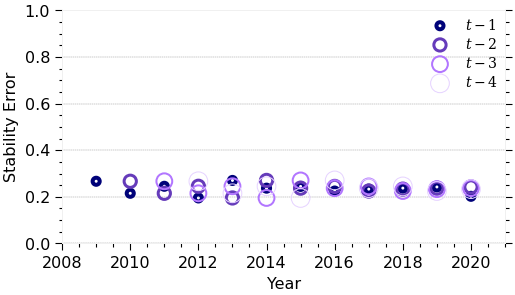

In [27]:
years = np.arange(2009, 2021, 1)

plt.figure(figsize=(8, 4), facecolor='white')
plt.axes().set_facecolor("white")
plt.ylabel(r'Stability Error')

plt.xlabel(r'Year')
#plt.xticks(np.arange(min(years), max(years)+1, 1)) #rotation=90
plt.grid(axis = 'x', linestyle = ":", linewidth=1)
plt.ylim(top=1, bottom = 0)
plt.xlim(left=2008, right=2021)

plt.scatter(years, dispT1, marker='o',   s = 50, facecolors='none', edgecolors= "#000279",  linewidth=4, label = '$t-1$')
plt.scatter(years, dispT2, marker='o',   s = 150, facecolors='none', edgecolors= "#653bba",  linewidth=3, label = '$t-2$')
plt.scatter(years, dispT3, marker='o',   s = 250, facecolors='none', edgecolors= "#b276ff",  linewidth=2, label = '$t-3$')
plt.scatter(years, dispT4, marker='o',   s = 350, facecolors='none',  edgecolors= '#e6d3ff',  linewidth=1, label = '$t-4$')


plt.legend(loc = 0, facecolor='#f1f1f1', edgecolor='#333333', borderpad = 1)
plt.show()

### DBSCAN

In [282]:
vector_size = 8
clustering = pd.DataFrame()

embs = dict()
for year in range(2008, 2021):
  embs.update({year:pd.read_csv('output/emb/{}_{}_aligned.csv'.format(year, vector_size), index_col= 0)})

for year in range(2008, 2021):
  sims = []
  ctrs = list(set(embs[year].index))
  for ctr1 in ctrs:
    for ctr2 in ctrs:
      norm_main, norm_context  = np.linalg.norm(embs[year].loc[ctr1,:]), np.linalg.norm(embs[year].loc[ctr2,:])     
      cosine = np.dot(embs[year].loc[ctr1,:], embs[year].loc[ctr2,:]) / (norm_main * norm_context)
      sims.append([ctr1, ctr2, cosine])

  simdf = pd.DataFrame(sims)
  dmat1 = simdf.loc[:, [0, 1, 2]].pivot(index = 0, columns = 1, values=2)
  dmat2 = dmat1.transpose()
  dmat = pd.DataFrame(index = dmat1.index, columns=dmat1.columns)
  dmat.loc[:,:] = np.where(pd.isna(dmat1), dmat2, dmat1)
  dmat = np.abs(1 - dmat)
  np.fill_diagonal(dmat.values, 0)

  X = dmat.round(6).fillna(0) ##check here
  model = DBSCAN(eps=0.14, min_samples=3, metric = 'precomputed').fit(X)

  model = model.fit(X)
  data = pd.DataFrame(zip(X.index, model.labels_)).rename(columns={1:year}).set_index(0)
  clustering = pd.concat([clustering, data], axis=1)

clustering.to_csv('output/dbscan/clustering.csv')

In [284]:
vector_size = 8
cls1, cls2, cls3, cls4, cls5 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

embs = dict()
for year in range(2008, 2021):
  embs.update({year:pd.read_csv('output/emb/{}_{}_aligned.csv'.format(year, vector_size), index_col= 0)})

for year in range(2008, 2021):
  sims = []
  ctrs = list(set(embs[year].index))
  for ctr1 in ctrs:
    for ctr2 in ctrs:
      norm_main, norm_context  = np.linalg.norm(embs[year].loc[ctr1,:]), np.linalg.norm(embs[year].loc[ctr2,:])     
      cosine = np.dot(embs[year].loc[ctr1,:], embs[year].loc[ctr2,:]) / (norm_main * norm_context)
      sims.append([ctr1, ctr2, cosine])

  simdf = pd.DataFrame(sims)
  dmat1 = simdf.loc[:, [0, 1, 2]].pivot(index = 0, columns = 1, values=2)
  dmat2 = dmat1.transpose()
  dmat = pd.DataFrame(index = dmat1.index, columns=dmat1.columns)
  dmat.loc[:,:] = np.where(pd.isna(dmat1), dmat2, dmat1)
  dmat = np.abs(1 - dmat)
  np.fill_diagonal(dmat.values, 0)

  X = dmat.round(6).fillna(0) ##check here

  model1 = DBSCAN(eps=0.18, min_samples=4, metric = 'precomputed').fit(X)
  data = pd.DataFrame(zip(X.index, model1.labels_)).rename(columns={1:year}).set_index(0)
  cls1 = pd.concat([cls1, data], axis=1)


  model2 = DBSCAN(eps=0.18, min_samples=3, metric = 'precomputed').fit(X)
  data = pd.DataFrame(zip(X.index, model2.labels_)).rename(columns={1:year}).set_index(0)
  cls2 = pd.concat([cls2, data], axis=1)


  model3 = DBSCAN(eps=0.14, min_samples=3, metric = 'precomputed').fit(X)
  data = pd.DataFrame(zip(X.index, model3.labels_)).rename(columns={1:year}).set_index(0)
  cls3 = pd.concat([cls3, data], axis=1)


  model4 = DBSCAN(eps=0.10, min_samples=3, metric = 'precomputed').fit(X)
  data = pd.DataFrame(zip(X.index, model4.labels_)).rename(columns={1:year}).set_index(0)
  cls4 = pd.concat([cls4, data], axis=1)


  model5 = DBSCAN(eps=0.10, min_samples=2, metric = 'precomputed').fit(X)
  data = pd.DataFrame(zip(X.index, model5.labels_)).rename(columns={1:year}).set_index(0)
  cls5 = pd.concat([cls5, data], axis=1)

In [287]:
cluster_quality = []
for year in range(2008, 2020):
  cluster_quality.append([year, 
                          normalized_mutual_info_score(cls1[year], cls1[year+1]),
                          normalized_mutual_info_score(cls2[year], cls2[year+1]),
                          normalized_mutual_info_score(cls3[year], cls3[year+1]),
                          normalized_mutual_info_score(cls4[year], cls4[year+1]),
                          normalized_mutual_info_score(cls5[year], cls5[year+1])

  ])

clqual = pd.DataFrame(cluster_quality)
clqual.head(3)

,0,1,2,3,4,5
0,2008,0.531308,0.575147,0.565727,0.445578,0.507249
1,2009,0.665797,0.622618,0.574265,0.479596,0.506994
2,2010,0.670876,0.667273,0.682556,0.487370,0.592540


#### Hierarchical Clustering

In [328]:

def save_dendrogram(Z, labs, txt):

  plt.figure(figsize=(4, 16), facecolor='white')
  plt.axes().set_facecolor("white")
  #plt.rcParams['font.family'] = 'DejaVu Sans'
  ##plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('Distance')
  #plt.ylabel('Cities')
  # plt.xticks = labs
  
  dendrogram(
      Z,
      #leaf_rotation=90.,  # rotates the x axis labels
      leaf_font_size=14,  # font size for the x axis labels
      labels = labs,
      color_threshold = 0.75,
      orientation = 'right'
      # truncate_mode = 'level',
      # p = 5
      
    )
  plt.ioff()
  #name = txt
  #plt.savefig(name)
  plt.show()
  plt.close('all')



def plot_dendrogram(model, labs, txt):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    save_dendrogram(linkage_matrix, labs, txt)


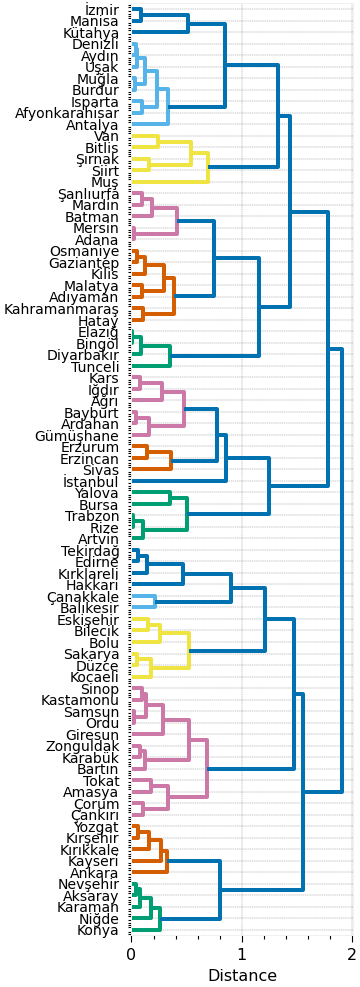

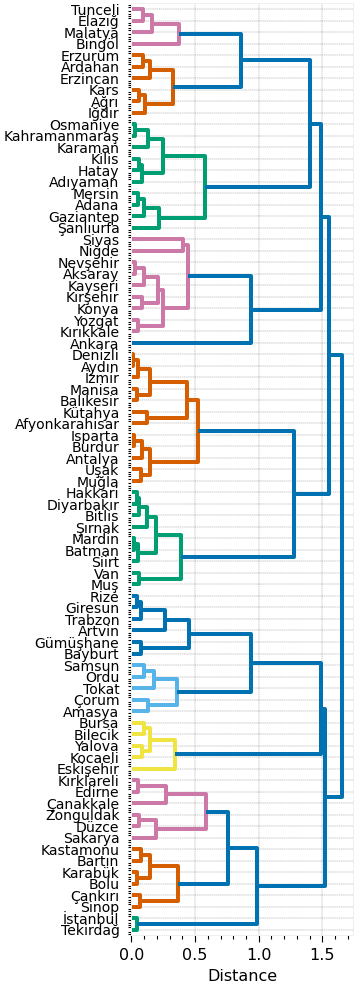

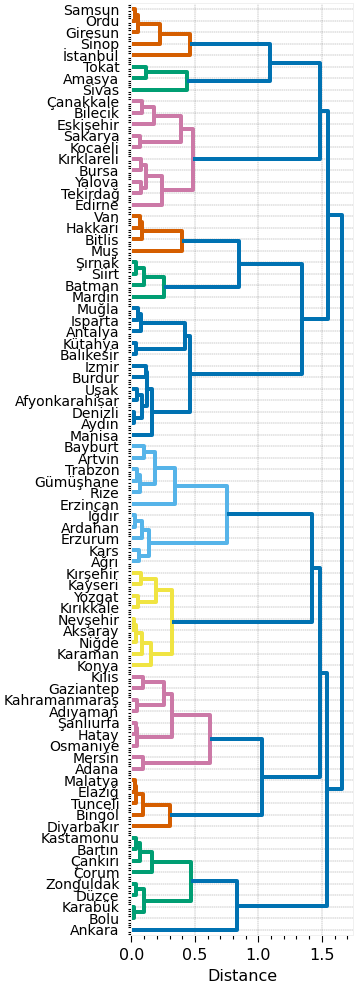

In [329]:

vector_size = 8
embs = dict()
for year in range(2008, 2021):
  embs.update({year:pd.read_csv('output/emb/{}_{}_aligned.csv'.format(year, vector_size), index_col= 0)})

for year in [2008, 2014, 2020]:
  sims = []
  ctrs = list(set(embs[year].index))
  for ctr1 in ctrs:
    for ctr2 in ctrs:
      norm_main, norm_context  = np.linalg.norm(embs[year].loc[ctr1,:]), np.linalg.norm(embs[year].loc[ctr2,:])     
      cosine = np.dot(embs[year].loc[ctr1,:], embs[year].loc[ctr2,:]) / (norm_main * norm_context)
      sims.append([ctr1, ctr2, cosine])

  simdf = pd.DataFrame(sims)
  dmat1 = simdf.loc[:, [0, 1, 2]].pivot(index = 0, columns = 1, values=2)
  dmat2 = dmat1.transpose()
  dmat = pd.DataFrame(index = dmat1.index, columns=dmat1.columns)
  dmat.loc[:,:] = np.where(pd.isna(dmat1), dmat2, dmat1)
  dmat = np.abs(1 - dmat)
  np.fill_diagonal(dmat.values, 0)

  X = dmat.round(6).fillna(0) ##check here
  model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity = 'precomputed', linkage = 'complete')

  model = model.fit(X)
  # plt.title('Hierarchical Clustering Dendrogram')
  mytxt = "output/dendrogram_{}.png".format(year)
  plot_dendrogram(model, X.index, mytxt)

In [31]:
vector_size = 8
cls1, cls2, cls3, cls4, cls5 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

embs = dict()
for year in range(2008, 2021):
  embs.update({year:pd.read_csv('output/emb/{}_{}_aligned.csv'.format(year, vector_size), index_col= 0)})

for year in range(2008, 2021):
  sims = []
  ctrs = list(set(embs[year].index))
  for ctr1 in ctrs:
    for ctr2 in ctrs:
      norm_main, norm_context  = np.linalg.norm(embs[year].loc[ctr1,:]), np.linalg.norm(embs[year].loc[ctr2,:])     
      cosine = np.dot(embs[year].loc[ctr1,:], embs[year].loc[ctr2,:]) / (norm_main * norm_context)
      sims.append([ctr1, ctr2, cosine])

  simdf = pd.DataFrame(sims)
  dmat1 = simdf.loc[:, [0, 1, 2]].pivot(index = 0, columns = 1, values=2)
  dmat2 = dmat1.transpose()
  dmat = pd.DataFrame(index = dmat1.index, columns=dmat1.columns)
  dmat.loc[:,:] = np.where(pd.isna(dmat1), dmat2, dmat1)
  dmat = np.abs(1 - dmat)
  np.fill_diagonal(dmat.values, 0)

  X = dmat.round(6).fillna(0) ##check here

  model1 = AgglomerativeClustering(n_clusters=6, affinity = 'precomputed', linkage = 'complete').fit(X)
  data = pd.DataFrame(zip(X.index, model1.labels_)).rename(columns={1:year}).set_index(0)
  cls1 = pd.concat([cls1, data], axis=1)


  model2 = AgglomerativeClustering(n_clusters=8, affinity = 'precomputed', linkage = 'complete').fit(X)
  data = pd.DataFrame(zip(X.index, model2.labels_)).rename(columns={1:year}).set_index(0)
  cls2 = pd.concat([cls2, data], axis=1)


  model3 = AgglomerativeClustering(n_clusters=10, affinity = 'precomputed', linkage = 'complete').fit(X)
  data = pd.DataFrame(zip(X.index, model3.labels_)).rename(columns={1:year}).set_index(0)
  cls3 = pd.concat([cls3, data], axis=1)


  model4 = AgglomerativeClustering(n_clusters=12, affinity = 'precomputed', linkage = 'complete').fit(X)
  data = pd.DataFrame(zip(X.index, model4.labels_)).rename(columns={1:year}).set_index(0)
  cls4 = pd.concat([cls4, data], axis=1)


  model5 = AgglomerativeClustering(n_clusters=14, affinity = 'precomputed', linkage = 'complete').fit(X)
  data = pd.DataFrame(zip(X.index, model5.labels_)).rename(columns={1:year}).set_index(0)
  cls5 = pd.concat([cls5, data], axis=1)

In [28]:
vector_size = 8
embs = dict()
for year in range(2008, 2021):
  embs.update({year:pd.read_csv('output/emb/{}_{}_aligned.csv'.format(year, vector_size), index_col= 0)})

clustering = dict()
for year in range(2008, 2021):
  sims = []
  ctrs = list(set(embs[year].index))
  for ctr1 in ctrs:
    for ctr2 in ctrs:
      norm_main, norm_context  = np.linalg.norm(embs[year].loc[ctr1,:]), np.linalg.norm(embs[year].loc[ctr2,:])     
      cosine = np.dot(embs[year].loc[ctr1,:], embs[year].loc[ctr2,:]) / (norm_main * norm_context)
      sims.append([ctr1, ctr2, cosine])

  simdf = pd.DataFrame(sims)
  dmat1 = simdf.loc[:, [0, 1, 2]].pivot(index = 0, columns = 1, values=2)
  dmat2 = dmat1.transpose()
  dmat = pd.DataFrame(index = dmat1.index, columns=dmat1.columns)
  dmat.loc[:,:] = np.where(pd.isna(dmat1), dmat2, dmat1)
  dmat = np.abs(1 - dmat)
  np.fill_diagonal(dmat.values, 0)

  X = dmat.round(6).fillna(0) ##check here

  ccls = pd.DataFrame()
  for i in range(81):
    model = AgglomerativeClustering(n_clusters=i+1, affinity = 'precomputed', linkage = 'complete')
    ccls = pd.concat([ccls, pd.DataFrame(model.fit(X).labels_)], axis=1)

  ccls.index = X.index.copy()
  ccls.columns = np.arange(1,82,1)
  clustering.update({year:ccls})

  clustering[year].to_csv('output/hclust/clustering_results_{}.csv'.format(year))